# Pyspatialml

Machine learning classification and regresssion modelling for spatial raster data.

## Example Classification

This is an example using the imagery data that is bundled with the package. This data is derived from the GRASS GIS North Carolina dataset and comprises Landsat 7 VNIR and SWIR bands along with some land cover training data.

First, import the extract and predict functions:

In [1]:
from osgeo import gdal
from pyspatialml import predict, extract
import os
import geopandas
import rasterio.plot
import matplotlib.pyplot as plt

%matplotlib inline

The GDAL virtual tile format provides a simple method of stacking and aligning a list of separate raster datasets:

In [12]:
band1 = 'lsat7_2000_10.tif'
band2 = 'lsat7_2000_20.tif'
band3 = 'lsat7_2000_30.tif'
band4 = 'lsat7_2000_40.tif'
band5 = 'lsat7_2000_50.tif'
band7 = 'lsat7_2000_70_32.tif'
predictors = [band1, band2, band3, band4, band5, band7]

# stack the bands into a single virtual tile format dataset:
vrt_file = 'landsat.vrt'
outds = gdal.BuildVRT(
    destName=vrt_file, srcDSOrSrcDSTab=predictors, separate=True,
    resolution='highest', resampleAlg='bilinear')
outds.FlushCache()

# load the vrt as a rasterio dataset:
src = rasterio.open(vrt_file)

Load some training data in the form of a shapefile of point feature locations:

In [3]:
training = geopandas.read_file('landclass96_roi.shp')

Show training data and a single raster band using numpy and matplotlib:

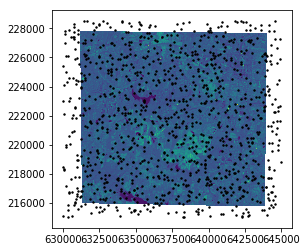

In [13]:
srr_arr = src.read(4, masked=True)
plt.imshow(srr_arr, extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top))
plt.scatter(x=training.bounds.iloc[:, 0],
            y=training.bounds.iloc[:, 1],
            s=2, color='black')
plt.show()

Create a training dataset by extracting the raster values at the training point locations:

In [20]:
X, y, xy = extract(dataset=src, response=training, field='id')

The response argument of the extract function can also take a raster data (GDAL-supported, single-band raster) where the training data are represented by labelled pixels:

In [ ]:
training = rasterio.open('training.tif')
X, y, xy = extract(dataset=src, response=training)

The training data is returned as a masked array, with training points that intersect nodata values in the predictor rasters being masked. This can cause problems with sklearn, so here we use only the valid entries:

In [15]:
X = X[~X.mask.any(axis=1)]
y = y[~y.mask]
xy = xy[~xy.mask.any(axis=1)]

Note the extract function returns three numpy-arrays as a tuple, consisting of the extracted pixel values (X), the response variable value (y) and the sampled locations (2d numpy array of x,y values). These represent masked arrays with nodata values in the predictors being masked, and the equivalent entries in y and xy being masked on axis=0.

Next we can train a logistic regression classifier:

In [21]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

# define the classifier with standardization of the input features in a pipeline
lr = Pipeline(
    [('scaling', StandardScaler()),
     ('classifier', LogisticRegressionCV(n_jobs=-1))])
 
# fit the classifier
lr.fit(X, y)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


TypeError: unhashable type: 'MaskedConstant'

After defining a classifier, a typical step consists of performing a cross-validation to evaluate the performance of the model. Scikit-learn provides the cross_validate function for this purpose. In comparison to non-spatial data, spatial data can be spatially correlated, which potentially can mean that geographically proximal samples may not represent truely independent samples if they are within the autocorrelation range of some of the predictors. This will lead to overly optimistic performance measures if samples in the training dataset / cross-validation partition are strongly spatially correlated with samples in the test dataset / cross-validation partition.

In this case, performing cross-validation using groups is useful, because these groups can represent spatial clusters of training samples, and samples from the same group will never occur in both the training and test partitions of a cross-validation. An example of creating random spatial clusters from point coordinates is provided here:

In [17]:
from sklearn.cluster import KMeans

# create 100 spatial clusters based on clustering of the training data point x,y coordinates
clusters = KMeans(n_clusters=100, n_jobs=-1)
clusters.fit(xy)

# cross validate
scores = cross_validate(
  lr, X, y, groups=clusters.labels_,
  scoring='accuracy',
  cv=3,  n_jobs=1)
scores['test_score'].mean()

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.674349678959608

Finally we might want to perform the prediction on the raster data. The estimator, raster and file_path fields are required. Predict_type can be either 'raw' to output a classification or regression result, or 'prob' to output class probabilities as a multi-band raster (a band for each class probability). In the latter case, indexes can also be supplied if you only want to output the probabilities for a particular class, or list of classes, by supplying the indices of those classes:

In [18]:
outfile = 'prediction.tif'
result = predict(estimator=lr, dataset=src,
                 file_path=outfile, predict_type='prob',
                 indexes=1, nodata = -99999)

100%|██████████| 111/111 [00:00<00:00, 414.33it/s]


In [19]:
arr = result.read(1, masked=True)
arr

masked_array(
  data=[[0.0008974253432825208, 0.0008974253432825208,
         0.0008974253432825208, ..., 0.0008974253432825208,
         0.0008974253432825208, 0.0008974253432825208],
        [0.0008974253432825208, 0.0008974253432825208,
         0.0008974253432825208, ..., 0.0008974253432825208,
         0.0008974253432825208, 0.0008974253432825208],
        [0.0008974253432825208, 0.0008974253432825208,
         0.0008974253432825208, ..., 0.0008974253432825208,
         0.0008974253432825208, 0.0008974253432825208],
        ...,
        [0.0008974253432825208, 0.0008974253432825208,
         0.0008974253432825208, ..., 0.0008974253432825208,
         0.0008974253432825208, 0.0008974253432825208],
        [0.0008974253432825208, 0.0008974253432825208,
         0.0008974253432825208, ..., 0.0008974253432825208,
         0.0008974253432825208, 0.0008974253432825208],
        [0.0008974253432825208, 0.0008974253432825208,
         0.0008974253432825208, ..., 0.0008974253432825208,
   

Display the results:

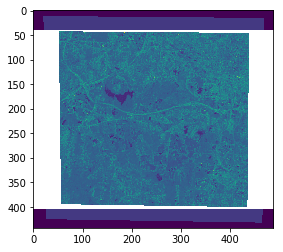

In [11]:
plt.imshow(result.read(1, masked=True))
plt.show()